# Não Espacial Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/cluster_brasil.ipynb`

## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

     |████████████████████████████████| 215 kB 681 kB/s eta 0:00:01
  Created wheel for pyshp: filename=pyshp-2.1.0-py3-none-any.whl size=32607 sha256=7bfd92fa008382e0dad56e8d10ef5cdbdac49b2c9fab1938e8d8495d68071ce7
  Stored in directory: /home/walef/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd24314fc84bc8afc9882deb33
Successfully built pyshp
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.7/site-packages (1.1.0)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


In [3]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(4000)

3000


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [4]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [5]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [6]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [7]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [8]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [9]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [10]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [11]:
dados.reset_index(level = 0, inplace = True)

In [12]:
dados.shape

(2293, 9)

In [13]:
dados = dados.merge(cod, on='mun')

In [14]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [15]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [16]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [17]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [18]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

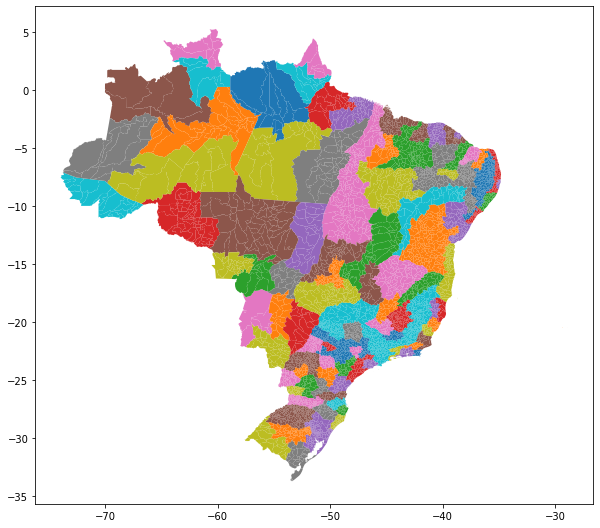

In [21]:
## dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10), k=4); # , cmap='OrRd',  cmap='plasma'

In [22]:
dados_cluster = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # 
dados_cluster = dados_cluster.drop(retirar, axis = 1)

## Análise de agrupamento

In [24]:
# subselecionar variáveis
X = dados_cluster.drop(['nome_mun', 'geometry'], axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [25]:
Z = linkage(X, method='ward')

In [26]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

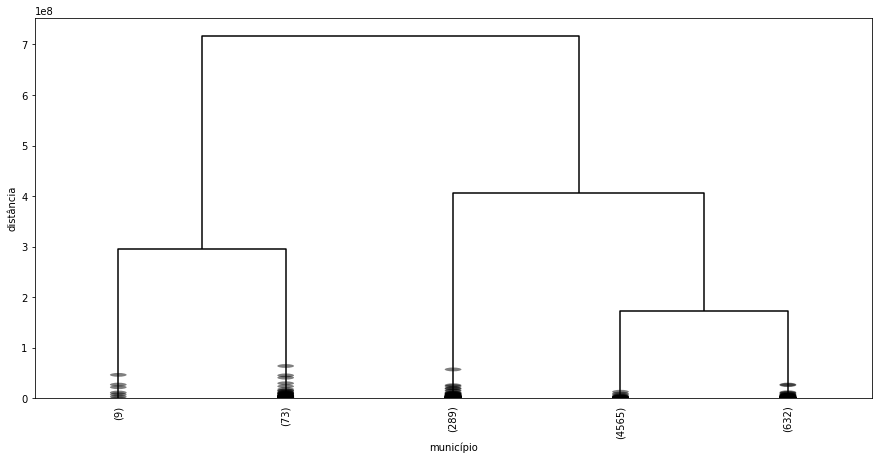

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

In [28]:
Z = linkage(X, method='ward')

In [29]:
## definir a distância de corte baseando no dendrograma
max_d = 2e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [30]:
dados_metrics = dados_cluster.drop(['nome_mun', 'geometry'], axis = 1)

In [31]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

13027.26 0.5 0.88


In [32]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_cluster['grupo'] = grupos
# moran_matrix.head(2)

In [33]:
# contagem de observações em cada grupo
dados_cluster.grupo.value_counts()

0    5197
1     289
2      73
3       9
Name: grupo, dtype: int64

In [34]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_cluster.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,4.617856,8.115662e+05,5.258312e+04,2.274076e+04,5.275999e+04,1578.019554,105.450437,1.089860
1,96.200692,1.806478e+07,1.216577e+06,5.251596e+05,1.358991e+06,20766.087682,1188.218581,28.162630
2,229.808219,4.974890e+07,3.583193e+06,1.517723e+06,4.511770e+06,36653.953425,1856.610137,77.301370
3,339.000000,1.229835e+08,9.916820e+06,4.146060e+06,4.786980e+06,31996.557778,1908.793333,51.222222


In [35]:
# mediana das variáveis para cada grupo
dados_cluster.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,0.0,0.000000e+00,0.00,0.00,0.00,0.0,0.00,0.0
1,73.0,1.712127e+07,1124175.08,471321.11,842603.90,15335.0,930.19,11.0
2,166.0,4.402479e+07,3410124.68,1418391.49,3027042.12,35755.0,1777.36,37.0
3,343.0,1.141694e+08,7717068.85,3052230.47,3902753.70,38217.7,1354.29,35.0


### As observações de cada grupo

In [36]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos

In [37]:
dados_cluster['grupo'] = dados_cluster['grupo'].astype('category')

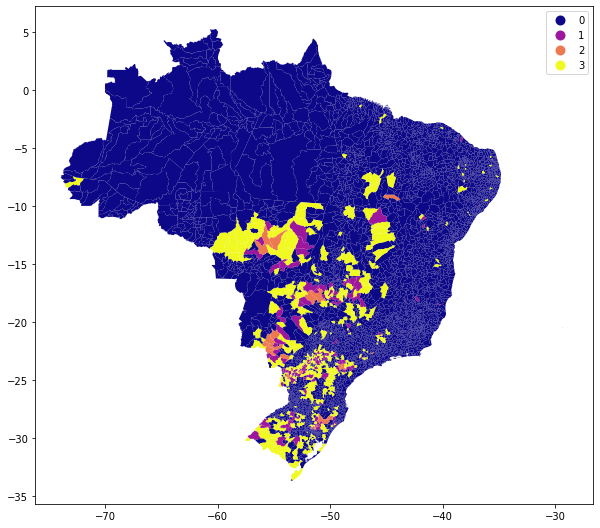

In [50]:
dados_cluster.plot(column='grupo', figsize=(10, 10), legend=True,cmap='plasma'); # , cmap='OrRd' k=4, 

## K-Médias

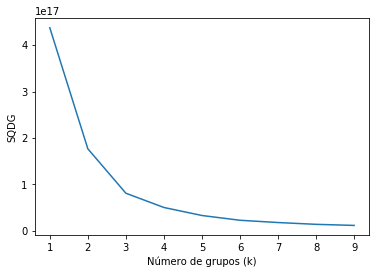

In [39]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_cluster.drop(['nome_mun', 'geometry'], axis=1))
    dados_cluster['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [40]:
k = 4

In [41]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [42]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_cluster['grupo'] = kmeans.labels_

### Métricas

In [43]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

14319.26 0.53 0.87


In [44]:
# contagens
dados_cluster.grupo.value_counts()

0    4985
3     427
1     129
2      27
Name: grupo, dtype: int64

In [45]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_cluster.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,2.832096,4.904948e+05,3.036531e+04,1.313843e+04,2.683226e+04,1023.368487,71.917338,0.539819,0.810431
1,170.542636,3.266863e+07,2.255736e+06,9.680482e+05,2.586697e+06,30138.478837,1615.316279,51.263566,4.224806
2,322.962963,9.006959e+07,7.031788e+06,2.939429e+06,7.294155e+06,41422.658148,1955.759259,108.518519,2.777778
3,62.740047,1.191031e+07,8.043801e+05,3.473661e+05,8.782186e+05,16529.993279,994.012974,17.969555,4.360656


In [46]:
# mediana das variáveis para cada grupo
dados_cluster.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
1,153.0,29105606.53,2113320.34,925609.19,1637321.23,27129.31,1637.38,23.0,6
2,218.0,76597614.84,6353738.82,2724013.32,4837731.45,40324.06,1777.36,50.0,2
3,47.0,11197997.88,734388.80,317207.56,542566.28,11453.00,763.25,8.0,5


In [47]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos K-médias

In [48]:
dados_cluster['grupo'] = dados_cluster['grupo'].astype('category')

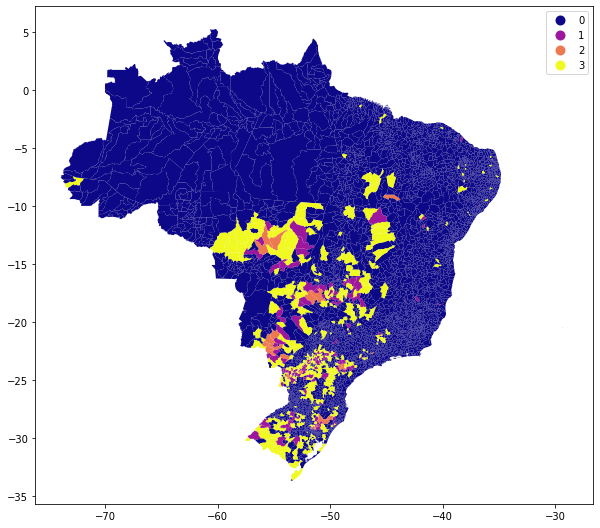

In [51]:
dados_cluster.plot(column='grupo', figsize=(10, 10), legend=True,cmap='plasma'); # , cmap='OrRd' k=4, 